In [3]:
import torch
import torch.nn as nn
from torchtext.data import Field, BucketIterator
from src.Self_attention_sequence_encoder import SelfAttentionEmbedder
from src.vocab_classes import BPE_Code_vocab
from src.trainers import Model_Trainer 
from src.useful_utils import load_CSN_data
from tokenizers import ByteLevelBPETokenizer
import tqdm.notebook as tqdm 
import numpy as np
from src.dataset_loaders import DummyDataset
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [6]:
CodeSearchNet_data_path = "/nfs/code_search_net_archive/python/final/jsonl/"
train_data, valid_data, test_data = load_CSN_data(CodeSearchNet_data_path)

In [3]:
train_data = train_data[:100000]

In [8]:
train_pairs = []
for sample in train_data:
    query = " ".join(sample["docstring_tokens"])
    doc = sample["code"].replace(sample["docstring"], "")
    train_pairs.append((query, doc))        

In [9]:
tokenizer = ByteLevelBPETokenizer("datasets/code_search_net/code_bpe_hugging_32k-vocab.json",
                                  "datasets/code_search_net/code_bpe_hugging_32k-merges.txt", )

In [10]:
cutoff = 500
trunk_train_pairs = [(q,d) for q,d in tqdm.tqdm(train_pairs) if len(tokenizer.encode(d).ids)<cutoff and len(tokenizer.encode(q).ids)<cutoff]

In [11]:
vocab = BPE_Code_vocab()

In [57]:
model = SelfAttentionEmbedder(vocab_size=vocab.vocab_size, embed_dim=128, att_heads=8, layers=3, dim_feedforward=512, loss_type="cosine")
model.init_train_params(lr=0.000005)

In [33]:
dataset = model.data2dataset(trunk_train_pairs, vocab)

KeyboardInterrupt: 

In [58]:
train_iterator = BucketIterator(
    dataset,
    batch_size = 32,
    repeat=True,
    shuffle=True,
    device = "cuda")

In [11]:
it = iter(train_iterator)


In [59]:
%%capture
model.to("cuda")

In [13]:
batch = next(it)
q_vec, d_vec = model(batch.query, batch.doc)
matrix = model.softmax_matrix(q_vec, d_vec)
matrix

tensor([[-11.4993, -13.5580, -11.1866,  ..., -12.2552, -15.6091, -14.0092],
        [ -8.0851, -10.3684, -18.2105,  ..., -20.0531, -16.1658,  -9.4214],
        [  1.3219,  -2.1274,  -8.4821,  ...,  -0.9855,  -7.7024,  -3.7673],
        ...,
        [-11.6607, -15.2321,  -7.0216,  ..., -14.3235, -12.8851,  -7.8668],
        [-15.7496, -19.4936, -18.1946,  ..., -22.8966, -20.5250, -16.4565],
        [-13.0613, -13.1255, -17.7572,  ..., -16.3334, -12.3127, -12.7974]],
       device='cuda:0', grad_fn=<MmBackward>)

In [14]:
torch.argmax(matrix, dim=0)

tensor([ 3, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11,  3, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
       device='cuda:0')

In [15]:
tmp_input = torch.tensor([[-1.,5],
                          [1,0]])
tmp_labels = torch.tensor([1,0])
model.cross_entropy(tmp_input, tmp_labels)

tensor([0.0025, 0.3133])

In [60]:
trainer = Model_Trainer(model, vocab)

'output_dir' not defined, training and model outputs won't be saved.


In [ ]:
train_logs = trainer.train(model, train_iterator, 500000, save_interval=10000000, log_interval=50)

tensor([[0.1415, 0.0880],
        [0.1546, 0.0568]], device='cuda:0', grad_fn=<MmBackward>)


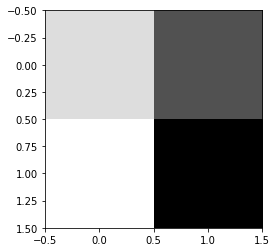

In [38]:
batch = next(iter(train_iterator))
q_vects, d_vects = model(batch.query,batch.doc)
model.eval()
outputs = model.cosine_matrix(q_vects, d_vects)
model.train()
plt.imshow(outputs.tolist(), cmap="gray")
print(outputs)

## Writing the same loss function as CodeSearchNet in pytorch

In [52]:
import tensorflow as tf

In [53]:
tf_query_representations = tf.constant([[-1,3.],[3,4],[5,6]])
tf_code_representations = tf.constant([[1,2.],[3,4],[5,6]])
margin = 1.

tf_query_norms = tf.norm(tf_query_representations, axis=-1, keepdims=True) + 1e-10
tf_code_norms = tf.norm(tf_code_representations, axis=-1, keepdims=True) + 1e-10

tf_cosine_similarities = tf.matmul(tf_query_representations / tf_query_norms,
                                tf_code_representations / tf_code_norms,
                                transpose_a=False,
                                transpose_b=True,
                                name='code_query_cooccurrence_logits',
                                )  # B x B
tf_similarity_scores = tf_cosine_similarities

# A max-margin-like loss, but do not penalize negative cosine similarities.
tf_neg_matrix = tf.linalg.diag(tf.fill(dims=[tf.shape(tf_cosine_similarities)[0]], value=float('-inf')))
tf_per_sample_loss = tf.maximum(0., margin
                                 - tf.linalg.diag_part(tf_cosine_similarities)
                                 + tf.reduce_max(tf.nn.relu(tf_cosine_similarities + tf_neg_matrix),
                                                 axis=-1))

In [54]:
tf_per_sample_loss

<tf.Tensor: id=36, shape=(3,), dtype=float32, numpy=array([0.86210316, 0.9986877 , 0.9986877 ], dtype=float32)>

### PyTorch version

In [55]:
query_representations = torch.tensor([[-1,3.],[3,4],[5,6]])
code_representations = torch.tensor([[1,2.],[3,4],[5,6]])
margin = 1.

query_norm = torch.norm(query_representations, dim=-1, keepdim=True) + 1e-10
code_norm = torch.norm(code_representations, dim=-1, keepdim=True) + 1e-10

# query_vector = query_vector/query_norm
# doc_vector = doc_vector/doc_norm
# batch_size = query_vector.shape[0]

cosine_similarities = torch.mm(torch.div(query_representations,query_norm),
                                torch.div(code_representations,code_norm).T
                                )

neg_matrix = torch.diag(torch.full((cosine_similarities.shape[0],), float('-inf')))

good_sample_loss = torch.diagonal(cosine_similarities)
bad_sample_loss = torch.max(cosine_similarities + neg_matrix, dim=-1)[0]


per_sample_loss = torch.clamp(margin - good_sample_loss + bad_sample_loss, min=0.0)

In [56]:
per_sample_loss

tensor([0.8621, 0.9987, 0.9987])

## TF CodeSearchNet softmax

In [211]:
tf_logits = tf.matmul(tf_query_representations,
                   tf_code_representations,
                   transpose_a=False,
                   transpose_b=True,
                   name='code_query_cooccurrence_logits',
                   )  # B x B

similarity_scores = tf_logits

tf_per_sample_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=tf.range(tf.shape(tf_code_representations)[0]),  # [0, 1, 2, 3, ..., n]
    logits=tf_logits
)

In [214]:
tf.range(tf.shape(tf_code_representations)[0])

<tf.Tensor: id=575, shape=(3,), dtype=int32, numpy=array([0, 1, 2], dtype=int32)>

In [226]:
tf_per_sample_loss

<tf.Tensor: id=566, shape=(3,), dtype=float32, numpy=array([ 8.018479, 14.000001,  0.      ], dtype=float32)>

In [224]:
logits = torch.mm(query_representations, code_representations.T)
criterion = nn.CrossEntropyLoss(reduction='none')
labels = torch.arange(0,code_representations.shape[0])
per_sample_loss = criterion(logits, labels)

In [225]:
per_sample_loss

tensor([ 8.0185, 14.0000, -0.0000])

In [209]:
logits

tensor([[ 5.,  9., 13.],
        [11., 25., 39.],
        [17., 39., 61.]])

## Using a dummy dataset

In [17]:
dummy_sampler = DummyDataset()
query_doc_pairs = dummy_sampler.document_pairs(20)
query_doc_pairs[:3]

[('I like carrots and onions', 'he likes carrots and onions'),
 ('I like peppers and carrots', 'he likes peppers and carrots'),
 ('I like banana and toast', 'he likes banana and toast')]

In [18]:
vocab = BPE_Code_vocab()

In [44]:
%%capture
model = SelfAttentionEmbedder(vocab_size=vocab.vocab_size, embed_dim=128, att_heads=8, layers=3, dim_feedforward=512, loss_type="cosine")
model.init_train_params(lr=0.2)
model.to("cuda")

In [45]:
dataset = model.data2dataset(query_doc_pairs, vocab)
train_iterator = BucketIterator(
    dataset,
    batch_size = 4,
    repeat=True,
    shuffle=True,
    device = "cuda")

In [46]:
trainer = Model_Trainer(model, vocab)
train_logs = trainer.train(model, train_iterator, 10000, save_interval=10000000, log_interval=50)

'output_dir' not defined, training and model outputs won't be saved.


KeyboardInterrupt: 

In [8]:
q, d = ('I like carrots and onions', 'he likes banana and toast')
q_ids = torch.tensor(vocab.encode_input(q)[0]).unsqueeze(1).to("cuda")
d_ids = torch.tensor(vocab.encode_input(d)[0]).unsqueeze(1).to("cuda")

tensor([[32000, 32000, 32000, 32000],
        [   40,    40,    40,    40],
        [ 2183,  2183,  2183,  2183],
        [ 1350, 18992,  1350,  7614],
        [  364,  5939,   364,   299],
        [  387,   387,   387,   764],
        [  813,  7614,   813,   387],
        [  368,   299,   368,   554],
        [32001,   764, 32001,  2112],
        [32002, 32001, 32002, 32001]], device='cuda:0') tensor([[32000, 32000, 32000, 32000],
        [  276,   276,   276,   276],
        [ 2183,  2183,  2183,  2183],
        [   82,    82,    82,    82],
        [ 1350, 18992,  1350,  7614],
        [  364,  5939,   364,   299],
        [  387,   387,   387,   764],
        [  813,  7614,   813,   387],
        [  368,   299,   368,   554],
        [32001,   764, 32001,  2112],
        [32002, 32001, 32002, 32001]], device='cuda:0')
tensor([[0.9469, 0.9498, 0.9344, 0.9440],
        [0.9475, 0.9425, 0.9382, 0.9466],
        [0.9370, 0.9360, 0.9267, 0.9388],
        [0.9348, 0.9376, 0.9196, 0.9319]

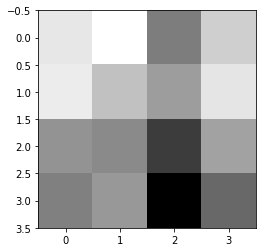

In [25]:
batch = next(iter(train_iterator))
q_vects, d_vects = model(batch.query,batch.doc)
model.eval()
outputs = model.cosine_matrix(q_vects, d_vects)
model.train()
plt.imshow(outputs.tolist(), cmap="gray")
print(batch.query,batch.doc)
print(outputs)

# Testing the CodeSearchNet dataset and subtask class

In [25]:
from src.dataset_loaders import CodeSearchNetDataset
import ast

In [14]:
CSN_datas_object = CodeSearchNetDataset()
train_pairs, valid_pairs, test_pairs = CSN_datas_object.get_data("python")

In [16]:
train_pairs[0]

(0, 1)

In [28]:
ast.parse(CSN_datas_object.lookup[1])

In [29]:
CSN_datas_object.lookup[1]

'def train(train_dir, model_save_path=None, n_neighbors=None, knn_algo=\'ball_tree\', verbose=False):\n    """\n    \n    """\n    X = []\n    y = []\n\n    # Loop through each person in the training set\n    for class_dir in os.listdir(train_dir):\n        if not os.path.isdir(os.path.join(train_dir, class_dir)):\n            continue\n\n        # Loop through each training image for the current person\n        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):\n            image = face_recognition.load_image_file(img_path)\n            face_bounding_boxes = face_recognition.face_locations(image)\n\n            if len(face_bounding_boxes) != 1:\n                # If there are no people (or too many people) in a training image, skip the image.\n                if verbose:\n                    print("Image {} not suitable for training: {}".format(img_path, "Didn\'t find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))\n            else:\n